In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from xgboost import XGBClassifier, plot_importance
from URLFeatures import URLFeatures
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             log_loss, roc_curve, precision_recall_curve, confusion_matrix, 
                             ConfusionMatrixDisplay)

# **URL Analysis**

* * *

## Dataset

The dataset contains more than 800,000 URLs where 52% of the domains are legitimate domains and the remaining 47% are phishing domains. And the dataset contains two columns url and label, where the label column represents values coded as 0 and 1, where 0 represents legitimate domains and 1 represents phishing domains and the two categories are almost equivalent in number so that there is no imbalance in the classes.

Obtained from: https://www.kaggle.com/datasets/harisudhan411/phishing-and-legitimate-urls

In [2]:
df = pd.concat(
    [
        pd.read_csv('../DATASETS/EXP/TRAIN_URLS.csv'), 
        pd.read_csv('../DATASETS/EXP/TEST_URLS.csv')
    ], 
    axis=0, 
    ignore_index=True
)

df

,text,label
0,zimbio.com/photos/John+Lewis/Emanuel+Cleaver,0
1,businesswire.com/news/home/20110812005191/en/S...,0
2,www.excelsoftware.com/linuxproducts.html,0
3,dinas.tomsk.ru/js/?paypal.com/uk/cgi-bin/,1
4,http://www.dartmouth-hitchcock.org/medical-inf...,0
...,...,...
823493,4000simin.or.kr/plus/html/bookmark/ii.php,1
823494,https://www.mecsccair.icu/,1
823495,https://docs.google.com/presentation/d/e/2PACX...,1
823496,https://ohjwaogtwn.duckdns.org/,1


## Feature Extraction

The features extracted from a URL are the basis for determining whether the URL is malicious or not. The success of any learning effort depends on the quality of the training data and, therefore, the quality of the features introduced into the model. We must ensure that the extracted features potentially represent or manifest the problem we are trying to model. By this we mean that variations in the features collected should represent the occurrence of the problem or its absence. So the question is: what features of a URL string can tell us whether it is malicious or not, or whether it is benign or not? There are three sources of information for extracting characteristics of a URL string.

- **Lexical features**: These are statistical features extracted from the literal URL string. For example, length of the URL string, number of digits, number of parameters in its query part, whether the URL is encoded, etc.

- **Host-based characteristics**: these are characteristics of the host name properties of the URL. They provide information about the host of the web page, e.g. country of registration, domain name properties, open ports, named servers, connection speed, lifetime since registration, etc.

- **Content features**: These are obtained from the HTML code downloaded from the web page. These features capture the structure of the web page and the content embedded in it. They will include information about script tags, embedded objects, executables, hidden elements, etc.

For this case, we will only focus on lexical features. This is because obtaining host-based and content-based features requires making multiple HTTP requests that, given the number of samples, would take forever to execute.

In [3]:
# Extraccion de caracteristicas
# -----------------------
def extract_features(url):
    
    urlfeatures = URLFeatures(url)
    
    features = {
        # LEXICAL CHARACTERISTICS
        'use_shortening_service': urlfeatures.use_shortening_services(),
        'prefix_suffix_presence': urlfeatures.prefix_suffix_presence(),
        'has_redirection': urlfeatures.has_redirection(),
        'has_haveat_sign': urlfeatures.has_haveat_sign(),
        'has_port': urlfeatures.has_port(),
        'has_admin_keyword': urlfeatures.has_admin_in_string(),
        'has_server_keyword': urlfeatures.has_server_in_string(),
        'has_login_keyword': urlfeatures.has_login_in_string(),
        'has_client_keyword': urlfeatures.has_client_in_string(),
        'host_is_ip': urlfeatures.host_is_ip(),
        'url_is_encoded': urlfeatures.url_is_encoded(),
        'scheme': urlfeatures.scheme(),
        'url_length': urlfeatures.url_length(),
        'path_length': urlfeatures.path_length(),
        'host_length': urlfeatures.host_length(),
        'url_entropy': urlfeatures.url_entropy(),
        'digits_num': urlfeatures.number_of_digits(),
        'subdirectories_num': urlfeatures.number_of_subdirectories(),
        'periods_num': urlfeatures.number_of_periods(),
        'params_num': urlfeatures.number_of_parameters(),
        'fragments_num': urlfeatures.number_of_fragments(),
    }
    
    return features

At the same time we extract the feaures, we can create the training and test sets

In [4]:
X = pd.DataFrame([extract_features(row.text) for row in df.itertuples(index=False)])
y = df['label']

X

,use_shortening_service,prefix_suffix_presence,has_redirection,has_haveat_sign,has_port,has_admin_keyword,has_server_keyword,has_login_keyword,has_client_keyword,host_is_ip,...,scheme,url_length,path_length,host_length,url_entropy,digits_num,subdirectories_num,periods_num,params_num,fragments_num
0,False,False,False,False,False,False,False,False,False,False,...,http,44,44,0,4.227,0,4,1,0,0
1,False,False,False,False,False,False,False,False,False,False,...,http,96,96,0,4.556,14,6,1,0,0
2,False,False,False,False,False,False,False,False,False,False,...,http,40,40,0,4.159,0,2,3,0,0
3,False,False,False,False,False,False,False,False,False,False,...,http,41,18,0,4.269,0,3,3,1,0
4,False,True,False,False,False,False,False,False,False,False,...,http,79,45,27,4.432,2,4,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823493,False,False,False,False,False,False,False,False,False,False,...,http,41,41,0,4.009,4,5,3,0,0
823494,False,False,False,False,False,False,False,False,False,False,...,https,26,1,17,3.719,0,2,2,0,0
823495,False,False,False,False,False,False,False,False,False,False,...,https,167,108,15,5.128,19,6,2,3,0
823496,False,False,False,False,False,False,False,False,False,False,...,https,31,1,22,4.042,0,2,2,0,0


As `scheme` feature is categorical, we'll use `get_dummies` pandas function to transform categorical variables into dummy/indicator variables. This is necessary due to BayesianSearch, which can't handle categorical data.

In [5]:
X = pd.get_dummies(X, columns=['scheme'])

After extracting these relevant features, we can split on training and test sets for the Classifier model

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y)

## XGBoost

XGBoost is a supervised machine learning algorithm that uses the principle of gradient boosting to generate predictive models based on decision trees. It differs from traditional decision trees in that it combines multiple trees sequentially, adjusting the parameters of each tree using an optimization algorithm based on gradient descent. In this way, it seeks to minimize an objective function that measures prediction error or some other metric. XGBoost also incorporates several regularization, parallelization and system optimization techniques to improve the performance and speed of the algorithm. XGBoost can be used for classification and regression problems, and has been shown to have high accuracy and robustness in many complex and heterogeneous data scenarios.

### Hyperparameter optimization with Bayesian Search

Bayesian search is a method that uses Bayesian statistics to find the best hyperparameters for a machine learning model. The idea is that you have an initial probability distribution over the possible values of the hyperparameters, called the prior, and you update this distribution as you evaluate the performance of the model with different combinations of hyperparameters, called the posterior. Bayesian search uses an optimization algorithm that selects the next combination of hyperparameters that maximizes an acquisition function, which measures the potential for improving model performance. In this way, Bayesian search explores the hyperparameter space efficiently and intelligently, without testing all possible combinations.

Some of the hyperparameters that can be optimized with BayesSearch for the XGBoost classifier are:

- **learning_rate** = this is the learning rate that controls the weight of each tree in the final prediction.

- **n_estimators** = is the number of trees that are built in the model.

- **max_depth** = is the maximum depth of each tree. 

- **min_child_weight** = is the minimum weight that a tree leaf must have to continue growing. 

- **subsample** = is the fraction of observations used to train each tree.

- **gamma** = is a regularization parameter used to control the minimum loss reduction to create a new split in a tree. That is, gamma determines how conservative the algorithm is in creating new nodes in the trees.

- **colsample_bytree** = is the fraction of variables used to train each tree.

In [7]:
# Define the Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True)

In [8]:
# Define the parameter grid
params = {
    'n_estimators': [80, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.5, 0.9],
    'gamma': [0, 0.5, 1, 2],
    'subsample': [0.5, 0.6, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.8],
    'min_child_weight': [1, 3, 5]
}

# Define the model
xgb = XGBClassifier(objective='binary:logistic')

# Perform the bayesian search
bs = BayesSearchCV(
    estimator=xgb, 
    search_spaces=params, 
    n_iter=10,
    n_points=2, 
    cv=skf, 
    scoring='accuracy', 
    n_jobs=4
)

bs.fit(xtrain, ytrain)

# Print the best parameters and best score
print("BEST PARAMETERS:")
pprint(bs.best_params_, indent=2)
print(f"\nBEST SCORE: {bs.best_score_:.3f}")

/opt/anaconda3/envs/machine_learning/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


BEST PARAMETERS:
OrderedDict([ ('colsample_bytree', 0.8),
              ('gamma', 1.0),
              ('learning_rate', 0.1),
              ('max_depth', 15),
              ('min_child_weight', 5),
              ('n_estimators', 150),
              ('subsample', 0.6)])

BEST SCORE: 0.907


### Optimized XGBoost Classifier

Now we can create the final XGBoost model with the best hyperparameters found

In [9]:
model = XGBClassifier(**bs.best_params_, objective='binary:logistic') 
model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Here, we can observe model performance through some metrics

In [10]:
ypred = model.predict(xtest)
ypred_proba = model.predict_proba(xtest)[:, 1]
print("\n#### RESULTS:")
print(f"Accuracy: {accuracy_score(ytest, ypred):.3f}")
print(f"Precision: {precision_score(ytest, ypred):.3f}")
print(f"Recall: {recall_score(ytest, ypred):.3f}")
print(f"F1-Score: {f1_score(ytest, ypred):.3f}")
print(f"Loss: {log_loss(ytest, ypred):.3f}")


#### RESULTS:
Accuracy: 0.907
Precision: 0.936
Recall: 0.861
F1-Score: 0.897
Loss: 3.354


Also, we're going to visualize its performance through the following plots:

- ROC-AUC curve 
- Precision-Recall curve
- Loss-Tree curve
- Confusion matrix

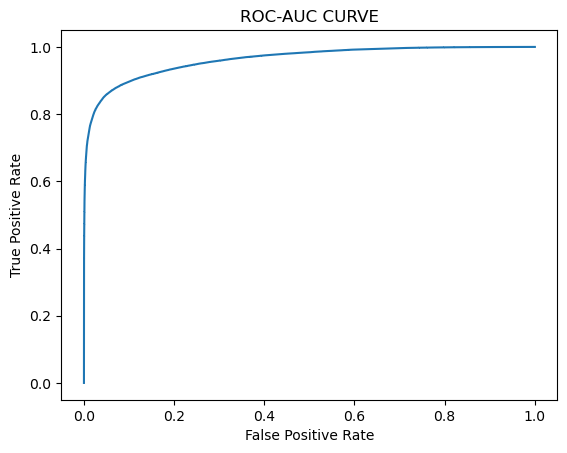

In [11]:
fpr, tpr, _ = roc_curve(ytest,  ypred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.title('ROC-AUC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

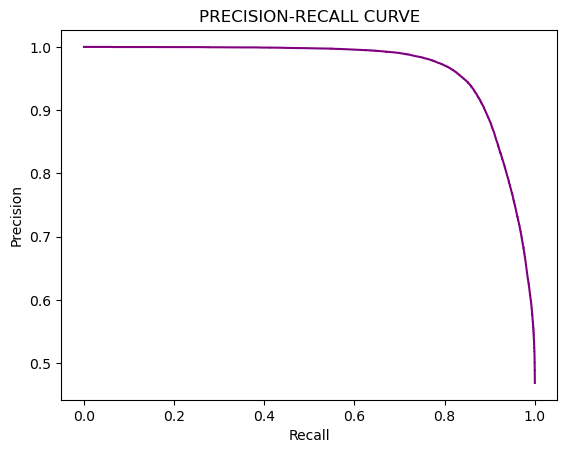

In [12]:
precision, recall, _ = precision_recall_curve(ytest, ypred_proba)
#create Precision-Recall curve
plt.plot(recall, precision, color='purple')
plt.title('PRECISION-RECALL CURVE')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

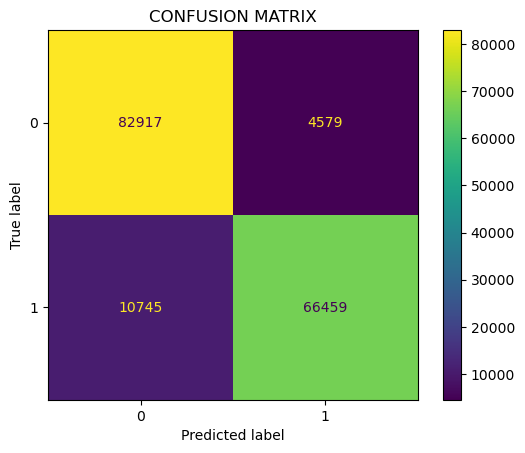

In [13]:
cm = confusion_matrix(ytest, ypred, labels=model.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot()
plt.title('CONFUSION MATRIX')
plt.show()

Additionally, we can visualize the relative importance of each feature for model prediction using the `plot_importance` function of XGBoost. Importance can be calculated based on: 'weight', 'gain' or 'cover'. Since we want to know which features are the ones that influence significantly in the predicitions, we'll use _gain_. **Gain** implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

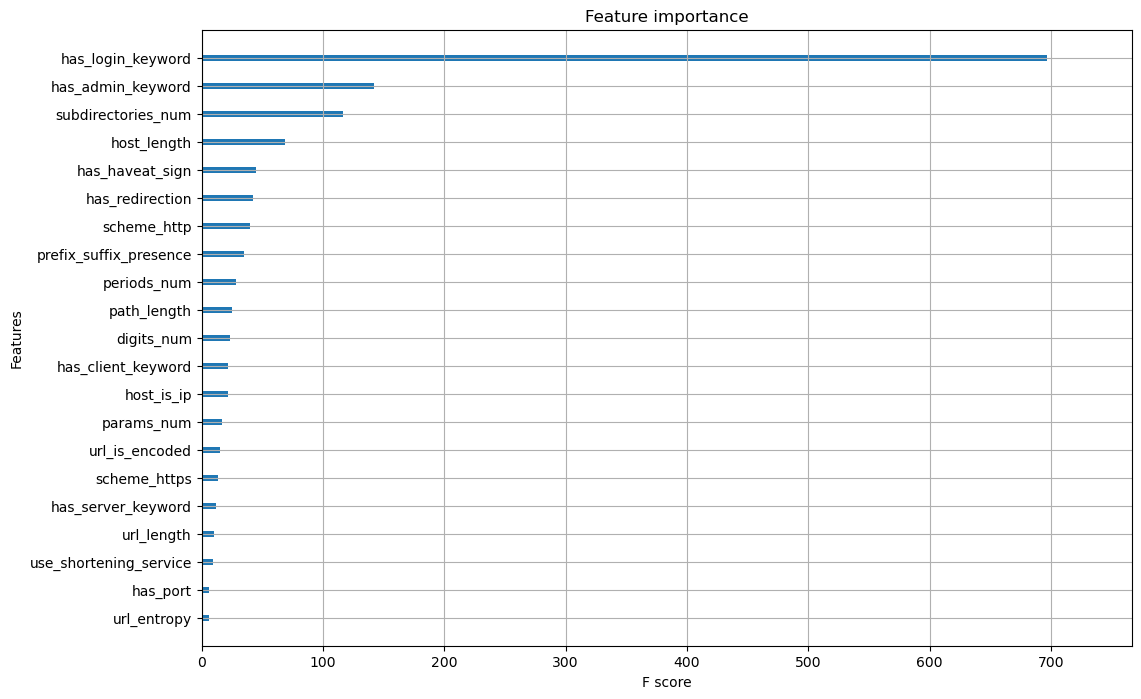

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model, ax=ax, importance_type='gain', show_values=False)
plt.show()

Based on this results, let's dig deeper in the most relevant features characteristics

In [15]:
# get 10 most relevant feautures
top_features = list({
    k: v for k, v in sorted(model.get_booster().get_score(importance_type='gain').items(), key=lambda item: item[1], reverse=True)
}.keys())[:10]

top_features

['has_login_keyword',
 'has_admin_keyword',
 'subdirectories_num',
 'host_length',
 'has_haveat_sign',
 'has_redirection',
 'scheme_http',
 'prefix_suffix_presence',
 'periods_num',
 'path_length']

In [16]:
# calculate gain averages of each feature by class
stats = pd.concat([
    xtrain.loc[ytrain == 0][top_features].mean(axis=0),
    xtrain.loc[ytrain == 1][top_features].mean(axis=0)
], axis=1).round(4).rename(columns={0: 'Benign', 1:'Phishing'})
stats

,Benign,Phishing
has_login_keyword,0.0014,0.0905
has_admin_keyword,0.0010,0.0191
subdirectories_num,3.3158,2.5254
host_length,1.7632,9.7551
has_haveat_sign,0.0006,0.0119
has_redirection,0.0002,0.0064
scheme_http,0.9542,0.7131
prefix_suffix_presence,0.0057,0.1100
periods_num,1.8238,2.4657
path_length,41.3168,25.1751


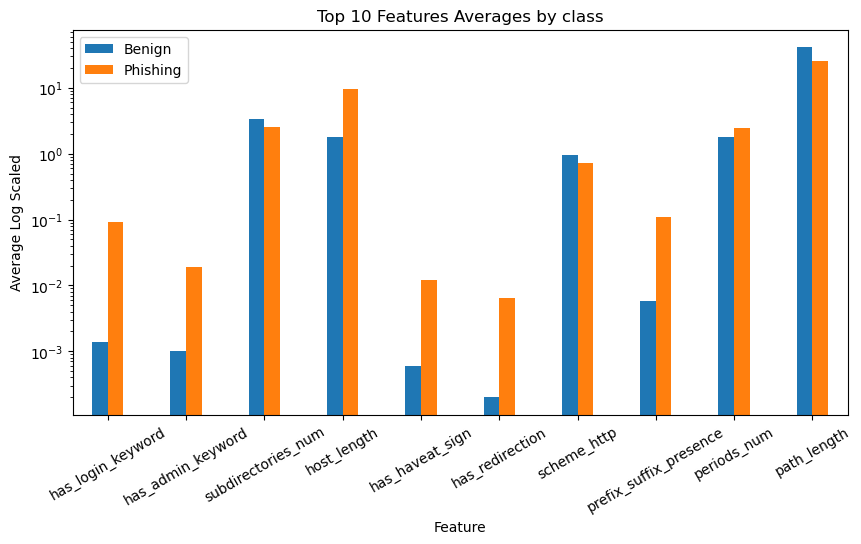

In [18]:
# plot features gain averages by class
stats.plot.bar(width=0.4, figsize=(10, 5))
plt.xlabel('Feature')
plt.ylabel('Average Log Scaled')
plt.title('Top 10 Features Averages by class')
plt.yscale('log')
plt.xticks(rotation=30)
plt.show() 